In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import matthews_corrcoef, make_scorer
import warnings
warnings.filterwarnings('ignore')
SEED = 42

#### 3.18.2. Последовательное удаление признаков.
##### _Отыскание веса класса "Дефолт", который доставляет максимум для MCC._
По мотивам статьи [_"How to Improve Class Imbalance using Class Weights in Machine Learning"._](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/)

In [2]:
data = pd.read_csv('data_for_WoE.csv')
data

,client_id,app_date,education,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,income,sna,first_time,foreign_passport,default,flag
0,25905,0.049878,0.197840,0.065296,-0.032082,-0.417369,-0.167706,0.056659,-0.084819,-0.076136,0.056983,-0.340801,0.169428,0.611943,0.452427,0.081641,0,train
1,63161,0.004902,0.197840,-0.052928,-0.032082,0.081082,-0.167706,0.056659,0.170803,0.175572,0.056983,0.233006,0.169428,0.611943,0.452427,0.081641,0,train
2,25887,0.049878,0.197840,0.065296,0.126941,0.081082,0.883227,0.056659,0.433255,-0.076136,-0.611418,-0.340801,0.056430,-0.289570,-0.487271,-0.597532,0,train
3,16222,0.131832,0.197840,-0.052928,-0.195731,0.081082,-0.167706,0.056659,-0.372642,0.047670,0.056983,0.233006,0.169428,-0.289570,-0.062081,0.081641,0,train
4,101655,-0.205295,-0.401516,0.065296,-0.072161,0.081082,-0.167706,-0.332053,0.645829,-0.076136,0.056983,0.233006,0.056430,-0.289570,-0.487271,-0.597532,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,83775,0.004902,0.197840,-0.052928,0.029163,0.081082,0.463471,0.056659,0.170803,0.175572,0.056983,0.233006,0.169428,0.611943,0.452427,0.081641,-100,test
110144,106254,-0.205295,-0.401516,-0.052928,-0.032082,-0.417369,-0.167706,0.056659,-0.786312,0.175572,0.056983,-0.340801,-0.371412,-0.289570,-0.487271,0.081641,-100,test
110145,81852,0.004902,-0.401516,0.065296,0.029163,0.081082,0.883227,0.056659,0.902034,-0.076136,0.056983,-0.340801,-0.371412,0.611943,0.235165,0.081641,-100,test
110146,1971,0.131832,0.040220,-0.052928,0.086444,0.081082,0.463471,0.056659,0.645829,0.047670,-0.611418,0.233006,0.056430,-0.289570,0.452427,0.081641,-100,test


In [3]:
#------------------------------------------------------------------------------#
y = data[data.flag=='train'].default
X = data[data.flag=='train'].drop(columns=['client_id', 'flag', 'default'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                    random_state=SEED, stratify=y)

mcc = make_scorer(matthews_corrcoef)
weight_class_1 = np.arange(0, 20, 0.01)
param_grid = {'class_weight': [{0: 1, 1: w1} for w1 in weight_class_1]}
lr = LogisticRegression(penalty='none', random_state=SEED, max_iter=1000)
gridsearch = GridSearchCV(estimator=lr, param_grid= param_grid,
                          cv=StratifiedKFold(), n_jobs=-1, 
                          scoring=mcc).fit(X_train, y_train)

,Экстремум
w1,4.630
MCC,0.245


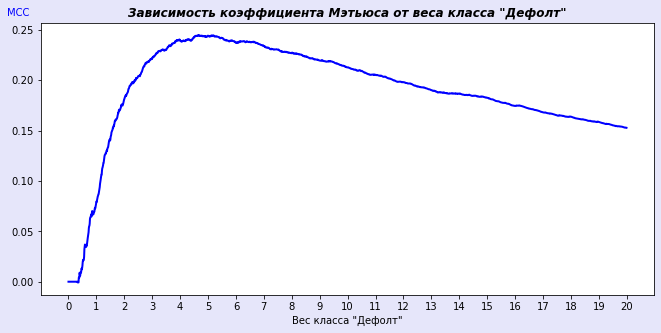

In [6]:
#------------------------------------------------------------------------------#
df_ = pd.DataFrame
df_MCC = df_({'w1': weight_class_1,
              'MCC': gridsearch.cv_results_['mean_test_score']})
#---
fig, ax = plt.subplots(figsize=(11,5), facecolor='Lavender')
plt.plot(df_MCC['w1'], df_MCC['MCC'], lw=2, color='b');
ax.set_title('Зависимость коэффициента Мэтьюса от веса класса "Дефолт"', 
              style='italic', fontweight='bold')
ax.set_xlabel('Вес класса "Дефолт"'); ax.set_xticks(range(21))
ax.set_ylabel('MCC', rotation=0, position=(0, 1.02), ha='left', color='blue')
#---
idx = df_MCC.MCC.idxmax()
df = df_MCC.loc[[idx], ['w1', 'MCC']].T; df.columns = ['Экстремум']
np.round(df, 3)

Сохраняем данные.

In [8]:
df_MCC.to_csv('df_MCC1_max_point_3_18_2.csv', index=False)